# Questionnaire analysis and exploratory factor analysis

**Analysis steps:**

1. ▶ **[📓 Questionnaire processing.ipynb](<Questionnaire%20processing.ipynb>)**
2. [📓 Factor analysis.ipynb](<Factor%20analysis.ipynb>)
3. [📓 Prediction analysis.ipynb](<Prediction%20analysis.ipynb>)
4. [📓 Prediction modelling.ipynb](<Prediction%20modelling.ipynb>)

This notebook processes questionnaire data and conducts some basic analyses.


## Imports


In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
from stats_utils.stats.plotting import plot_grouped_corr_heatmap
import statsmodels.api as sm
from statsmodels.formula.api import ols
from interactive_avoidance.style import set_style
from interactive_avoidance.utils import check_directories

# Check that we're in the right directory
check_directories()

set_style("style.mplstyle")

Changing directory to root directory of repository...
Font saved to: ./fonts
Matplotlib style set to: style.mplstyle with font Heebo


### Load in questionnaire data


In [2]:
# Load item-level data
questionnaire_data = pd.read_csv(
    "data/questionnaires/questionnaire_data_wide-reverse_coded.csv"
)

# Load scale-level data (just because this contains the attention check info)
attention_checks = pd.read_csv(
    "data/questionnaires/questionnaire_data-reverse_coded-subscales.csv"
)
attention_checks = attention_checks[
    attention_checks.columns.intersection(
        ["subjectID", "attention_check_failed", "inattentive_incorrect"]
    )
]
questionnaire_data = questionnaire_data.merge(attention_checks, on="subjectID")

# Print number of subjects
print("Number of subjects = {}".format(len(questionnaire_data["subjectID"].unique())))

Number of subjects = 1025


## Get measures for EFA

For exploratory factor analysis, we're going to use 6 of our measures:

1. STICSA (trait)
2. CAPE
3. PID-5
4. ESI (short form)
5. ASRS
6. AQ-10


In [3]:
efa_measures = ["STICSA_T", "CAPE", "PID_5", "ESI_SF", "ASRS", "AQ_10"]

# Copy data
efa_data = questionnaire_data.copy()

# Reverse code some measures so that higher scores always indicate more of the construct
esi_columns = [i for i in efa_data.columns if "ESI_SF" in i]
efa_data[esi_columns] = 3 - efa_data[esi_columns]

# Reverse code AQ_10
aq10_columns = [i for i in efa_data.columns if "AQ_10" in i]
efa_data[aq10_columns] = 3 - efa_data[aq10_columns]

# Store number of subjects
n_subjects = len(efa_data["subjectID"].unique())

# Excluding subjects who fail one than one attention check.
efa_data = efa_data[efa_data["attention_check_failed"] < 1]

# Excluding subjects who fail more than one infrequency item check.
efa_data = efa_data[efa_data["inattentive_incorrect"] <= 1]

# Print number of subjects removed
print(
    "Number of subjects removed = {}".format(
        n_subjects - len(efa_data["subjectID"].unique())
    )
)
print("Number of subjects remaining = {}".format(len(efa_data["subjectID"].unique())))

# Columns to include
columns_include = [
    i
    for i in efa_data.columns
    if any([j in i for j in efa_measures]) or i == "subjectID"
]

# Select columns
efa_data = efa_data[columns_include]

# Drop rows with missing data
efa_data = efa_data.dropna()

# we shouldn't have any duplicate rows, but just in case
efa_data = efa_data.drop_duplicates(["subjectID"])

# add a column to indicate the study as we'll be combining the data from the two studies
efa_data["study"] = "predator"

print(
    "Number of subjects in final dataset = {}".format(
        len(efa_data["subjectID"].unique())
    )
)

efa_data.head()

Number of subjects removed = 20
Number of subjects remaining = 1005
Number of subjects in final dataset = 996


,subjectID,AQ_10__1,AQ_10__10,AQ_10__2,AQ_10__3,AQ_10__4,AQ_10__5,AQ_10__6,AQ_10__7,AQ_10__8,...,STICSA_T__20,STICSA_T__21,STICSA_T__3,STICSA_T__4,STICSA_T__5,STICSA_T__6,STICSA_T__7,STICSA_T__8,STICSA_T__9,study
0,subject001,2.0,2.0,2.0,1.0,2.0,1.0,0.0,1.0,0.0,...,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,predator
1,subject002,3.0,3.0,0.0,1.0,0.0,1.0,0.0,2.0,2.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,predator
2,subject003,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,predator
3,subject004,1.0,1.0,1.0,2.0,1.0,2.0,1.0,2.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,predator
4,subject005,2.0,1.0,2.0,1.0,2.0,1.0,0.0,1.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,predator


### Load data from another dataset

We have another dataset which included these same measures, so we can extract the data from this dataset and use it to boost the sample size for EFA.


In [4]:
efa_grid_study_data = pd.read_csv(
    "data/questionnaires/grid_study_efa_questionnaire_data.csv"
)
efa_grid_study_data.head()

,ESI_SF__2,ESI_SF__3,ESI_SF__51,ESI_SF__53,ESI_SF__60,ESI_SF__61,ESI_SF__67,ESI_SF__69,ESI_SF__70,ESI_SF__75,...,PID_5__25,PID_5__4,PID_5__5,PID_5__6,PID_5__7,PID_5__8,PID_5__9,PID_5__10,study,subjectID
0,0,0,0,0,0,2,0,2,0,1,...,1,2,0,2,0,2,3,2,grid,1
1,2,1,2,0,0,2,0,3,1,0,...,0,2,1,0,1,2,2,0,grid,3
2,3,2,3,2,1,3,2,1,2,0,...,1,2,2,1,0,1,2,1,grid,4
3,0,1,1,0,0,2,1,2,0,1,...,0,1,0,0,1,3,3,3,grid,5
4,2,2,1,0,0,3,0,3,0,1,...,3,2,1,1,1,3,2,3,grid,6


### Combine the two datasets


In [5]:
# ensure the columns are in the same order
efa_grid_study_data = efa_grid_study_data[efa_data.columns]

# concatenate the two datasets
combined_efa_data = pd.concat([efa_data, efa_grid_study_data])

# Rename columns
combined_efa_data = combined_efa_data.rename(
    columns={
        col: col.replace("_", "", 1).replace("__", "_")
        for col in combined_efa_data.columns
    }
)

## save
combined_efa_data.to_csv(
    "data/questionnaires/combined_efa_questionnaire_data.csv", index=False
)

# Store subjectID and study columns as separate dataframe
subjectID_study = combined_efa_data[["subjectID", "study"]]

# Drop subject ID and study columns
combined_efa_data = combined_efa_data.drop(columns=["subjectID", "study"])

### Plot correlation matrix


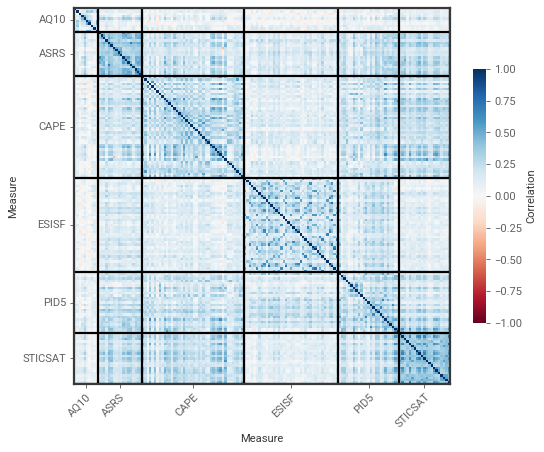

In [6]:
ax = plot_grouped_corr_heatmap(
    combined_efa_data,
    heatmap_kwargs={"linewidths": 0, "vmax": 1, "vmin": -1},
    subplot_kwargs={"figsize": (7, 7)},
)

# Set colorbar title
cbar = ax.collections[0].colorbar
cbar.ax.set_ylabel("Correlation")

# Set X and Y axis labels
ax.set_xlabel("Measure")
ax.set_ylabel("Measure")

# Save
if not os.path.isdir("figures/efa"):
    os.mkdir("figures/efa")
plt.savefig("figures/efa/efa_corr_heatmap.svg", bbox_inches="tight")

## Look at effects on motivation and fear of the predator


In [13]:
# Load in questionnaire data with sumscores
questionnaire_data_sumscores = pd.read_csv(
    "data/questionnaires/questionnaire_data-reverse_coded-subscales.csv"
)

print(
    "Number of subjects in questionnaire data = {}".format(
        len(questionnaire_data_sumscores["subjectID"].unique())
    )
)

# Select subjects in the combined EFA dataset
questionnaire_data_sumscores = questionnaire_data_sumscores[
    questionnaire_data_sumscores["subjectID"].isin(efa_data["subjectID"])
]

# Exclude subjects with gender != 0 or 1
questionnaire_data_sumscores = questionnaire_data_sumscores[
    questionnaire_data_sumscores["gender"].isin([0, 1])
]

print(
    "Number of subjects after exclusions = {}".format(
        len(questionnaire_data_sumscores["subjectID"].unique())
    )
)

Number of subjects in questionnaire data = 1025
Number of subjects after exclusions = 989


### Associations between trait anxiety and motivation/fear


In [14]:
# statsmodels api
import statsmodels.api as sm
from statsmodels.formula.api import ols

# run regression predicting 0motivation from all factors in 4 factor model
model = ols(
    "motivation ~ age + gender + STICSA_T", data=questionnaire_data_sumscores
).fit()

# print summary
print(model.summary().tables[1])

                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     87.6069      1.900     46.117      0.000      83.879      91.335
age           -0.0037      0.043     -0.086      0.931      -0.087       0.080
gender        -1.8202      1.017     -1.789      0.074      -3.817       0.176
STICSA_T      -0.0154      0.047     -0.332      0.740      -0.107       0.076


In [15]:
# run regression predicting 0motivation from all factors in 4 factor model
model = ols("scared ~ age + gender + STICSA_T", data=questionnaire_data_sumscores).fit()

# print summary
print(model.summary().tables[1])

                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     57.7888      3.286     17.584      0.000      51.340      64.238
age           -0.3466      0.074     -4.709      0.000      -0.491      -0.202
gender         9.4732      1.760      5.383      0.000       6.019      12.927
STICSA_T       0.3775      0.081      4.688      0.000       0.219       0.536


### Associations between current anxiety/depression symptoms and motivation/fear


In [16]:
# statsmodels api
import statsmodels.api as sm
from statsmodels.formula.api import ols

# run regression predicting 0motivation from all factors in 4 factor model
model = ols(
    "motivation ~ age + gender + GAD_7 + PHQ_8", data=questionnaire_data_sumscores
).fit()

# print summary
print(model.summary().tables[1])

                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     93.0310      2.215     42.002      0.000      88.681      97.381
age           -0.0894      0.054     -1.660      0.097      -0.195       0.016
gender        -1.6299      1.246     -1.308      0.191      -4.078       0.818
GAD_7          0.1397      0.182      0.768      0.443      -0.217       0.497
PHQ_8         -0.3857      0.178     -2.163      0.031      -0.736      -0.036


In [17]:
# run regression predicting 0motivation from all factors in 4 factor model
model = ols(
    "scared ~ age + gender + GAD_7 + PHQ_8", data=questionnaire_data_sumscores
).fit()

# print summary
print(model.summary().tables[1])

                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     59.3830      3.799     15.630      0.000      51.922      66.844
age           -0.2805      0.092     -3.036      0.003      -0.462      -0.099
gender         8.8134      2.138      4.122      0.000       4.615      13.012
GAD_7          0.8620      0.312      2.763      0.006       0.249       1.475
PHQ_8         -0.0352      0.306     -0.115      0.908      -0.636       0.565


## Figure to show effects on motivation and fear


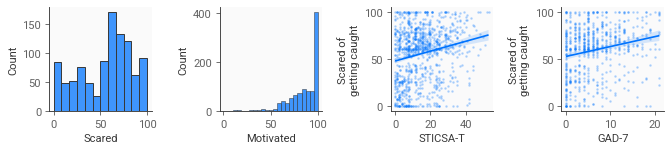

In [18]:
f, ax = plt.subplots(1, 4, figsize=(8.5, 2.0))

sns.histplot(questionnaire_data_sumscores["scared"], ax=ax[0])
ax[0].set_xlabel("Scared")

sns.histplot(questionnaire_data_sumscores["motivation"], ax=ax[1])
ax[1].set_xlabel("Motivated")

sns.regplot(
    x="STICSA_T",
    y="scared",
    data=questionnaire_data_sumscores,
    scatter_kws={"alpha": 0.2, "s": 2},
    ax=ax[2],
)
ax[2].set_xlabel("STICSA-T")
ax[2].set_ylabel("Scared of\ngetting caught")

sns.regplot(
    x="GAD_7",
    y="scared",
    data=questionnaire_data_sumscores,
    scatter_kws={"alpha": 0.2, "s": 2},
    ax=ax[3],
)
ax[3].set_xlabel("GAD-7")
ax[3].set_ylabel("Scared of\ngetting caught")

sns.despine()

plt.tight_layout()

plt.savefig("figures/scared_motivation.svg", dpi=300, bbox_inches="tight")
plt.savefig("figures/scared_motivation.pdf", dpi=300, bbox_inches="tight")